# TensorFlow Training with SageMaker (Part 4/4)

Download | Structure | Preprocessing (TensorFlow) | **Train Model (TensorFlow)**

**Notes**: 
* This notebook should be used with the conda_tensorflow2_p36 kernel
* This notebook is part of a series of notebooks beginning with `01_download_data`, `02_structuring_data` and `03_tensorflow_preprocessing`.
* You can also explore training with SageMaker's built-in algorithms and PyTorch by running `04a_builtin_training` and `04c_pytorch_training`, respectively.

<pre>
</pre>

## Overview
* #### [Dependencies](#idg4b.1)
* #### [Algorithm hyperparameters](#idg4b.2)
* #### [Review the training script](#idg4b.3)
* #### [Estimator configuration](#idg4b.4)
* #### [Training on EC2 instances](#idg4b.5)
* #### [Load trained model and predict on test data](#idg4b.6)

<pre>
</pre>

<a id='idg4b.1'></a>
## Dependencies
___

### Install tensorflow-datasets package

In [ ]:
import sys

!{sys.executable} -m pip install -q "tensorflow-datasets"

### Import packages and check SageMaker version

In [2]:
import pickle
import pathlib
import tarfile
import sagemaker
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sagemaker.tensorflow import TensorFlow

### Load S3 bucket name
An S3 bucket for this guide was created in Part 3.

In [ ]:
with open("pickled_data/tensorflow_bucket_name.pickle", "rb") as f:
    bucket_name = pickle.load(f)
print(bucket_name)

<pre>
</pre>

<a id='idg4b.2'></a>
## Algorithm hyperparameters
___
Hyperparamters represent the tuning knobs for our algorithm which we set before training begins. Typically they are pre-set to defaults so if we don't specify them we can still run the training algorithm, but they usually need tweaking to get optimal results. What these values should be depend entirely on the dataset. Unfortunately, there's no formula to tell us what the best settings are, we just have to try them ourselves and see what we get, but there are best practices and tips to help guide us in choosing them.

* **Optimizer** - The optimizer refers to the optimization algorithm being used to choose the best weights. For deep learning on image data, SGD or ADAM is typically used.

* **Learning Rate** - After each batch of training we update the model's weights to give us the best possible results for that batch. The learning rate controls by how much we should update the weights. Best practices dictate a value between 0.2 and .001, typically never going higher than 1. The higher the learning rate, the faster your training will converge to the optimal weights, but going too fast can lead you to overshoot the target. In this example, we're using the weights from a pre-trained model so we'd want to start with a lower learning rate because the weights have already been optimized and we don't want move too far away from them.

*  **Epochs** - An epoch refers to one cycle through the training set and having more epochs to train means having more oppotunities to improve accracy. Suitable values range from 5 to 25 epochs depending on your time and budget constraints. Ideally, the right number of epochs is right before your validation accuracy plateaus.

* **Batch Size** - Training on batches reduces the amount of data you need to hold in RAM and can speed up the training algorithm. For these reasons the training data is nearly always batched. The optimal batch size will depended on the dataset, how large the images are and how much RAM the training computer has. For a dataset like ours reasonable vaules would be bewteen 8 and 64 images per batch.

* **Loss** - This is the type of loss function that will be used by the optimizer to update the model's weights during training. For training on a dataset with with more than two classes, the most common loss function is Cross-Entropy Loss. In TensorFlow, if your labels are a single number corresponding to a class (i.e. mutually excusive) then the type of loss is Sparse Categorical Crossentropy.

<pre>
</pre>

<a id='idg4b.3'></a>
## Review the training script
___

### Helper functions
These helper functions define transformations needed to be done to our TFRecords datasets before training. For more in-depth info see the Pre-processing guide in this series.

In [22]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 7,23p

def tfrecord_parser(record):
    features = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(record, features)
    return tf.io.decode_jpeg(parsed_features['image_raw']), parsed_features['label']

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.1)
    return (image, label)


<pre>
</pre>

### Execution safety
For safety we wrap the training code in this standard if statement though it is not strictly required

In [24]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 25p

if __name__ == "__main__":


<pre>
</pre>

### Parse argument variables
These argument variables are passed via the hyperparameter argument for the estimator config and the input argument to the fit method.

In [25]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 27,34p

    arg_parser = argparse.ArgumentParser()
    arg_parser.add_argument('--epochs', type=int, default=50)
    arg_parser.add_argument('--batch-size', type=int, default=4)
    arg_parser.add_argument('--learning-rate', type=float, default=0.001)
    
    arg_parser.add_argument('--train-dir', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    arg_parser.add_argument('--validation-dir', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    args, _ = arg_parser.parse_known_args()


<pre>
</pre>

### Use autotune for configuring parallelization
In order to speed up training, TensorFlow can spread certain tasks scross mutilple cores. It can be difficult to determine the optimal number of workers to spread the work across (too few and you underutilizing your GPU and too many will cause a lag due to the overhead of scheduling the work). Luckily, TensorFlow comes wih a method of determing the right amount based on the computer doing the training.

In [26]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 36p

    AUTOTUNE = tf.data.experimental.AUTOTUNE


<pre>
</pre>

### Load the datasets
The training and validation datasets are loaded. Augmentation is applied to the training data, but not the validation data. We don't need to do any resizing or rescaling because we already applied this transformation when we converted the images to TDRecord files.

In [28]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 38,56p

    train_data = pathlib.Path(args.train_dir) / 'train.tfrecord'
    val_data = pathlib.Path(args.validation_dir) / 'val.tfrecord'
    
    train_ds = tf.data.TFRecordDataset(
        filenames = [train_data.as_posix()], 
        num_parallel_reads = AUTOTUNE)
    
    val_ds = tf.data.TFRecordDataset(
        filenames = [val_data.as_posix()], 
        num_parallel_reads = AUTOTUNE)

    train_ds = train_ds.map(tfrecord_parser, num_parallel_calls=AUTOTUNE) \
                       .map(augment, num_parallel_calls=AUTOTUNE) \
                       .batch(args.batch_size) \
                       .prefetch(AUTOTUNE)

    val_ds = val_ds.map(tfrecord_parser, num_parallel_calls=AUTOTUNE) \
                   .batch(args.batch_size) \
                   .prefetch(AUTOTUNE)


<pre>
</pre>

### Determine if GPU is available
This will set the device of training as the GPU if a GPU is available, otherwise it'll use a CPU

In [30]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 58,63p

    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    if any(gpu_devices):
        device = gpu_devices[0].device_type
    else:
        device = '/cpu:0' 
    print(f'Training with: {device}')


<pre>
</pre>

### Create and modify the base model
First the device context is set to ensure we're using the proper device (GPU or CPU). Then we use a ResNet50 architecture and initialize the weights to weights pre-trainged on the ImageNet dataset. Since the top layer of the pretained model is configured for the ImageNet images, we need to removbe the classification layer (`inlcude_top=False`) and replace it with a classifiaction layer for our 11 animals.

In [32]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 65,73p

    with tf.device(device):

        base_model = tf.keras.applications.ResNet50(
            include_top=False, 
            weights='imagenet')

        global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        output = tf.keras.layers.Dense(11, activation="softmax")(global_avg)
        model = tf.keras.Model(inputs=base_model.input, outputs=output)


<pre>
</pre>

### Define the optimizer and train the model
For this example we'll use SGD to optimize the weights of the model. At the end of training the weights for the epoch with the best validation accuracy are saved so we can load the model later for predictions on our test dataset.

In [33]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 75,85p

        optimizer = tf.keras.optimizers.SGD(lr=args.learning_rate, momentum=0.9, decay=0.01)

        model.compile(
            loss="sparse_categorical_crossentropy", 
            optimizer=optimizer,
            metrics=["accuracy"])
        
        print('Beginning Training...')
        model.fit(train_ds, epochs=args.epochs, validation_data=val_ds, verbose=2)

        model.save('/opt/ml/model/model')


<pre>
</pre>

<a id='idg4b.4'></a>
## Estimator configuration
___

These define the the resources to use for training and how they are configured. Here are some important one to single out:

* **entry_point (str)** – Path (absolute or relative) to the Python source file which should be executed as the entry point to training. If source_dir is specified, then entry_point must point to a file located at the root of source_dir.

* **framework_version (str)** – PyTorch version you want to use for executing your model training code. Defaults to None. Required unless image_uri is provided. List of supported versions: https://github.com/aws/sagemaker-python-sdk#pytorch-sagemaker-estimators.

* **py_version (str)** – Python version you want to use for executing your model training code. One of ‘py2’ or ‘py3’. Defaults to None. Required unless image_uri is provided.

* **source_dir (str)** – Path (absolute, relative or an S3 URI) to a directory with any other training source code dependencies aside from the entry point file (default: None). If source_dir is an S3 URI, it must point to a tar.gz file. Structure within this directory are preserved when training on Amazon SageMaker.

* **dependencies (list[str])** – A list of paths to directories (absolute or relative) with any additional libraries that will be exported to the container (default: []). The library folders will be copied to SageMaker in the same folder where the entrypoint is copied. If ‘git_config’ is provided, ‘dependencies’ should be a list of relative locations to directories with any additional libraries needed in the Git repo.

* **git_config (dict[str, str])** – Git configurations used for cloning files, including repo, branch, commit, 2FA_enabled, username, password and token. The repo field is required. All other fields are optional. repo specifies the Git repository where your training script is stored. If you don’t provide branch, the default value ‘master’ is used. If you don’t provide commit, the latest commit in the specified branch is used.

* **role (str)** – An AWS IAM role (either name or full ARN). The Amazon SageMaker training jobs and APIs that create Amazon SageMaker endpoints use this role to access training data and model artifacts. After the endpoint is created, the inference code might use the IAM role, if it needs to access an AWS resource.

* **instance_count (int)** – Number of Amazon EC2 instances to use for training.

* **instance_type (str)** – Type of EC2 instance to use for training, for example, ‘ml.c4.xlarge’.

* **volume_size (int)** – Size in GB of the EBS volume to use for storing input data during training (default: 30). Must be large enough to store training data if File Mode is used (which is the default).

* **model_uri (str)** – URI where a pre-trained model is stored, either locally or in S3 (default: None). If specified, the estimator will create a channel pointing to the model so the training job can download it. This model can be a ‘model.tar.gz’ from a previous training job, or other artifacts coming from a different source. In local mode, this should point to the path in which the model is located and not the file itself, as local Docker containers will try to mount the URI as a volume.

* **output_path (str)** - S3 location for saving the training result (model artifacts and output files). If not specified, results are stored to a default bucket. If the bucket with the specific name does not exist, the estimator creates the bucket during the fit() method execution. file:// urls are used for local mode. For example: ‘file://model/’ will save to the model folder in the current directory.

<pre>
</pre>

<a id='idg4b.5'></a>
## Training on an EC2 instance
___


### Define hyperparameters for training

In [5]:
hyperparameters = {
    "epochs": 3,
    "batch-size": 32,
    "learning-rate": 0.001,
}

### Define the estimator configuration

In [6]:
estimator_config = {
    "entry_point": "tensorflow_train.py",
    "source_dir": "training_tensorflow",
    "framework_version": "2.3",
    "py_version": "py37",
    "instance_type": "ml.p3.2xlarge",
    "instance_count": 1,
    "role": sagemaker.get_execution_role(),
    "hyperparameters": hyperparameters,
    "output_path": f"s3://{bucket_name}",
}

In [7]:
tf_estimator = TensorFlow(**estimator_config)

### Define the data channels for training and validation

In [8]:
s3_data_channels = {
    "training": f"s3://{bucket_name}/data/train/train.tfrecord",
    "validation": f"s3://{bucket_name}/data/val/val.tfrecord",
}

### Train the model

In [ ]:
tf_estimator.fit(s3_data_channels)

<pre>

</pre>

<a id='idg4b.6'></a>
## Load trained model and predict on test data
___

After training the model and saving it to S3, we can retrive it and load it back into TensorFlow to generate predicions. It's important that after training we evaluate the model on the test data. This data has never been seen by the model for trainging or for choosing the best epoch.

### Download the trained model from S3

In [10]:
sagemaker.s3.S3Downloader().download(tf_estimator.model_data, "training_tensorflow")

In [11]:
tfile = tarfile.open("training_tensorflow/model.tar.gz")
tfile.extractall("training_tensorflow")

### Load the trained model

In [12]:
model = tf.keras.models.load_model("training_tensorflow/model")

### Load images from the test dataset for predictions

In [13]:
image_folder = tfds.ImageFolder("./data_structured")

In [14]:
def tfrecord_parser(record):
    features = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "depth": tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "image_raw": tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(record, features)
    return tf.io.decode_jpeg(parsed_features["image_raw"]), parsed_features["label"]

In [15]:
test_ds = tf.data.TFRecordDataset(filenames=["data_tfrecord/test.tfrecord"], num_parallel_reads=2)

test_ds = test_ds.map(tfrecord_parser, num_parallel_calls=2).as_numpy_iterator()

### Link the model predictions (0 to 9) back to original class names (bear to zebra)

In [16]:
with open("pickled_data/category_labels.pickle", "rb") as f:
    category_labels = pickle.load(f)

category_labels = {idx: name for idx, name in enumerate(sorted(category_labels.values()))}

### Show validation images with model predictions
Re-run cell to see more predictions

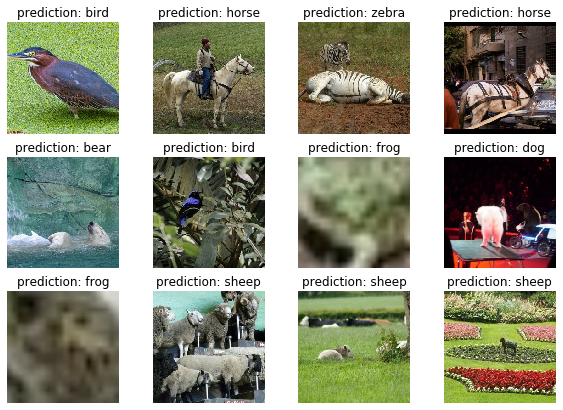

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))

for ax in axs.flatten():
    sample = next(iter(test_ds))
    image = sample[0]
    pred = model.predict(tf.expand_dims(image, axis=0))
    pred_name = category_labels[np.argmax(pred)]
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"prediction: {pred_name}")

<pre>
</pre>

## Rollback to default version of SDK and TensorFlow
Only do this if you're done with this guide and want to use the same kernel for other notebooks with an incompatible version of the SageMaker SDK or TensorFlow.

In [15]:
# print(f'Original version: sagemaker {original_sagemaker_version[0]}, tensorflow {original_tensorflow_version[0]}')
# print(f'Current version:  sagemaker {sagemaker.__version__}, tensorflow {tf.__version__}')
# print('')
# print(f'Rolling back to sagemaker {original_sagemaker_version[0]}, tensorflow {original_tensorflow_version[0]}')
# print('Restart notebook kernel to use changes.')
# print('')
# s = f'sagemaker=={original_sagemaker_version[0]} tensorflow-serving-api=={original_tensorflow_version[0]} tensorflow=={original_tensorflow_version[0]}'
# !{sys.executable} -m pip install -q {s}

<pre>
</pre>

## Next Steps
This concludes the Image Data Guide for SageMaker's TensorFlow framework. If you'd like to deploy your model and get predictions on your test data, all the info you'll need to get going can be foud here: [Deploy Models for Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html)